In [72]:
# python files that contain the functions to aquire and prep the data
import acquire
import prepare

# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import hypothesis testing
from scipy.stats import chi2_contingency
from scipy.stats import ttest_1samp

print('Imports complete.')

Imports complete.


In [2]:
# aquire the data
df = acquire.get_churn_data()

#prep the data
df = prepare.prep_telco_df(df)

#split the data, exploring on train only
train, test, validate = prepare.train_test_validate(df)

No duplicates found.
Dummy variables for gender created as "male".
Yes/No column values changed to boolean, 0 as no and 1 as yes
Combined variable for phone_service + multiple lines created.
Combined variable for partner + dependents created.
Changed streaming tv and movies to 0 for no, 1 for streams.
Changed backup and security to 0 for no, 1 for having the feature.
Added feature for tenure in years.
Converted total_charges to float for easier manipulation.
Data prep complete.


train shape:  (5070, 23) , validate shape:  (1268, 23) , test shape:  (705, 23)

train percent:  72.0 , validate percent:  18.0 , test percent:  10.0


In [3]:
train.head().T

,855,2823,5656,1016,1175
customer_id,6923-EFPNL,2004-OCQXK,2542-HYGIQ,8205-MQUGY,9555-SAHUZ
senior_citizen,0,0,0,0,0
tenure_months,4,1,1,12,38
phone_service,2,1,1,1,1
internet_service_type_id,1,2,3,1,1
online_security,0,0,0,1,1
online_backup,0,0,0,0,1
device_protection,No,No,No internet service,No,No
tech_support,No,No,No internet service,No,No
streaming_tv,0,0,0,0,0


# Exploring Train Dataset
- what tenure length cohort(s) are more likely to churn?
- features that indicate higher rates of churn?
- price point that increases churn rate?
- does higher average monthly prices cause higher churn?
- does service type influence monthly price?

### Categorical vs. Continuous Features
- Categorical
    - senior citizen
    - gender
    - phone service
    - internet service
    - security
    - backup
    - device protection
    - tech support
    - streaming
    - contract
    - partner+dependents
    - CHURN (our target variable)
- Continuous
    - total charges
    - monthly charges
    - tenure in months
    - tenure in years

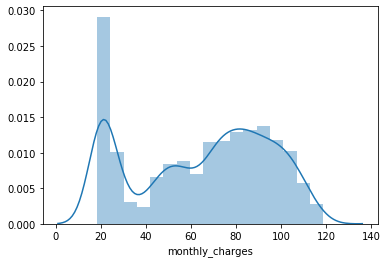

In [40]:
# distribution of monthly charges
sns.distplot(train.monthly_charges)

### Tenure by Months
- Customers at the beginning are most likely to churn
- Customers also leave once they reach 70 months with the company

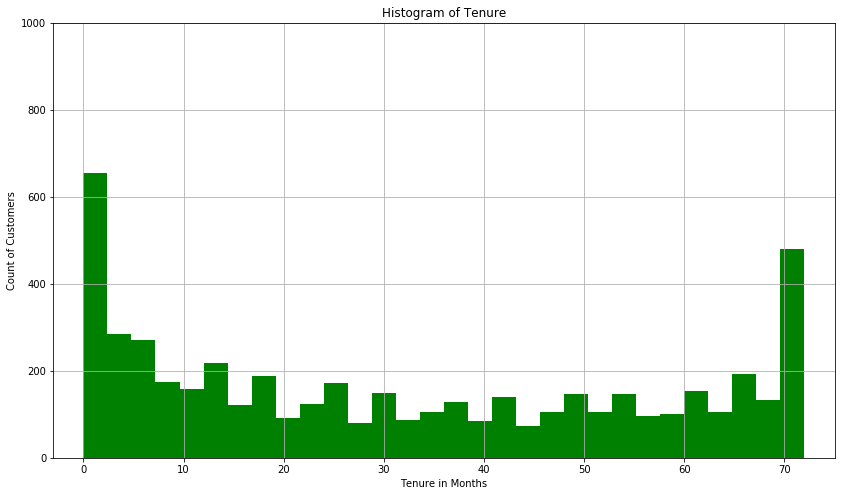

In [4]:
plt.figure(figsize=(14,8))
n, bins, patches = plt.hist(train.tenure_months, 30, facecolor='g', align='mid')


plt.xlabel('Tenure in Months')
plt.ylabel('Count of Customers')
plt.title('Histogram of Tenure')
plt.xlim(-3, 75)
plt.ylim(0, 1000)
plt.grid(True)
plt.show()

### Does security or not cause different rates of churn?
- null hypothesis: having online security does not affect churn
- alternative hypothesis: having online security affects a customer churning

In [71]:
# support and churn are two categorical features
# we can use the chi-square test for this

# set alpha first
alpha = .05

# create a cross table
table = pd.crosstab(train.churn, train.online_security)
print('Crosstab of churn and security:\n\n',table)

chi2, p, degf, expected = chi2_contingency(table)

print('\n\np = ',p)
print('\nRounded p_value:',round(p,2))
print('\np_value is less than alpha, so we can reject our null hyopthesis.')

Crosstab of churn and security:

 online_security     0     1
churn                      
0                2486  1234
1                1139   211


p =  3.293136414042123e-34

Rounded p_value: 0.0

p_value is less than alpha, so we can reject our null hyopthesis.


Let's test this feature with a T-test
- need one categorical feature and one continuous feature
- category as having online security or not
- continuous as tenure in months
    - null hypothesis: having online security does cause longer tenure in months
    - alternative hypothesis: having online security causes a cusomer to have longer tenure in months
- One sample, one tailed T-test

In [99]:
# first, we have to set alpha
alpha = .05

# define our population churn (if having internet) and the subpopulation (having online security) tenure
# We will not include custoemrs without internet, because they do not have the option for security
pop_tenure = train[train.internet_service_type != 'None'].tenure_months
security_tenure = train[train.online_security == 1].tenure_months

stats, p = ttest_1samp(security_tenure, pop_tenure.mean())

print('\n\np = ',p/2)
print('\nRounded p_value:',round(p/2,2))
print('\np_value is less than alpha, so we can reject our null hyopthesis.')
stats



p =  4.0234427284036393e-79

Rounded p_value: 0.0

p_value is less than alpha, so we can reject our null hyopthesis.


20.011050042043383

### Does backup or not cause different rates of churn?
- null hypothesis: having online backup does not affect churn
- alternative hypothesis: having online backup affects a customer churning